# Goal of Analysis:

### 1. Train a model to predict whether the loan will be repaid or not

### 2. What are the most important variables on the prediction?

### 3. Are there any other variables, not in the data provided, that you'd have liked to include in the model?

### Part 1: Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import lightgbm as lgb

%matplotlib inline

In [2]:
loan = pd.read_csv('loan_table.csv', parse_dates = ['date'])
loan.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [3]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   loan_id       101100 non-null  int64         
 1   loan_purpose  101100 non-null  object        
 2   date          101100 non-null  datetime64[ns]
 3   loan_granted  101100 non-null  int64         
 4   loan_repaid   47654 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 3.9+ MB


In [4]:
borrower = pd.read_csv('borrower_table.csv')
borrower.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [5]:
borrower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   is_first_loan                                    101100 non-null  int64  
 2   fully_repaid_previous_loans                      46153 non-null   float64
 3   currently_repaying_other_loans                   46153 non-null   float64
 4   total_credit_card_limit                          101100 non-null  int64  
 5   avg_percentage_credit_card_limit_used_last_year  94128 non-null   float64
 6   saving_amount                                    101100 non-null  int64  
 7   checking_amount                                  101100 non-null  int64  
 8   is_employed                                      101100 non-null  int64  
 9   yearly_salary  

In [6]:
# in order to see the situation of loan repaid, we only filter the data which the loan was granted

data = pd.merge(left = loan, right = borrower, on = 'loan_id')
data = data[data['loan_granted']==1]

data.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,580653,other,2012-06-27,1,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,172419,business,2012-05-21,1,0.0,1,NaN,NaN,2900,0.76,1050,3695,1,34800,31,4
6,780070,business,2012-03-14,1,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,303138,emergency_funds,2012-08-31,1,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,91475,investment,2012-05-25,1,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 3 to 101098
Data columns (total 16 columns):
 #   Column                                           Non-Null Count  Dtype         
---  ------                                           --------------  -----         
 0   loan_id                                          47654 non-null  int64         
 1   loan_purpose                                     47654 non-null  object        
 2   date                                             47654 non-null  datetime64[ns]
 3   loan_granted                                     47654 non-null  int64         
 4   loan_repaid                                      47654 non-null  float64       
 5   is_first_loan                                    47654 non-null  int64         
 6   fully_repaid_previous_loans                      21865 non-null  float64       
 7   currently_repaying_other_loans                   21865 non-null  float64       
 8   total_credit_card_limit            

In [8]:
missing = data.isnull().sum()
missing.sort_values(ascending=False)

fully_repaid_previous_loans                        25789
currently_repaying_other_loans                     25789
avg_percentage_credit_card_limit_used_last_year      903
loan_id                                                0
loan_purpose                                           0
date                                                   0
loan_granted                                           0
loan_repaid                                            0
is_first_loan                                          0
total_credit_card_limit                                0
saving_amount                                          0
checking_amount                                        0
is_employed                                            0
yearly_salary                                          0
age                                                    0
dependent_number                                       0
dtype: int64

The missing values are mostly associated with loan repaid and credit limit.

### Part 2: Data Preprocess

In [9]:
# dealing with the date and month

data['month'] = data['date'].apply(lambda x: x.month)
data['week'] = data['date'].apply(lambda x: x.week)
data['dayofweek'] = data['date'].apply(lambda x: x.dayofweek)

data = data.drop(labels=['loan_id','date','loan_granted'],axis = 1, inplace = False)

In [10]:
# fill null values

median = data['avg_percentage_credit_card_limit_used_last_year'].median()
data = data.fillna({'avg_percentage_credit_card_limit_used_last_year':median})

data = data.fillna({'fully_repaid_previous_loans': -1, 'currently_repaying_other_loans': -1})

In [11]:
data = data.drop(labels=['month','week','dayofweek'], axis = 1, inplace = False)
data.head()

,loan_purpose,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,other,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,business,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4
6,business,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,emergency_funds,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,investment,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


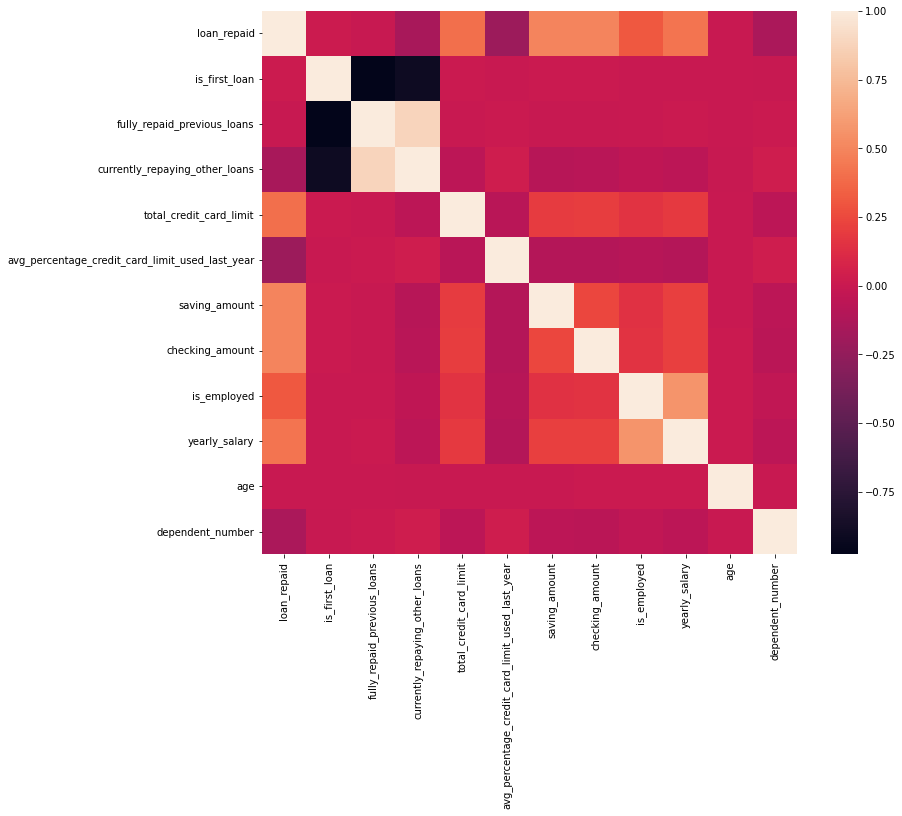

In [12]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(data.corr(),ax=ax)
plt.show()

We can take a look at the correlation chart, loans are basically have higher correlation with credit limit.

#### In order to fit the model, I need to use labelencoder or one hot encoder to transform the data.

In [13]:
encoder = LabelEncoder()
data['loan_purpose'] = encoder.fit_transform(data['loan_purpose'])
data.head()

,loan_purpose,loan_repaid,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
3,4,1.0,0,1.0,0.0,5400,0.52,3345,2764,1,15800,58,4
4,0,0.0,1,-1.0,-1.0,2900,0.76,1050,3695,1,34800,31,4
6,0,1.0,0,1.0,0.0,7800,0.30,4206,4368,1,51100,51,2
7,1,0.0,0,0.0,1.0,4300,1.02,886,1597,1,15000,59,2
8,3,1.0,0,1.0,0.0,3900,0.65,1837,3795,1,12000,24,1


In [14]:
categorical_feature = ['loan_purpose', 'is_first_loan', 'fully_repaid_previous_loans', 
                       'currently_repaying_other_loans', 'is_employed']
target = 'loan_repaid'
data[categorical_feature] = data[categorical_feature].astype('category')
data[target] = data[target].astype('category')

In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47654 entries, 3 to 101098
Data columns (total 13 columns):
 #   Column                                           Non-Null Count  Dtype   
---  ------                                           --------------  -----   
 0   loan_purpose                                     47654 non-null  category
 1   loan_repaid                                      47654 non-null  category
 2   is_first_loan                                    47654 non-null  category
 3   fully_repaid_previous_loans                      47654 non-null  category
 4   currently_repaying_other_loans                   47654 non-null  category
 5   total_credit_card_limit                          47654 non-null  int64   
 6   avg_percentage_credit_card_limit_used_last_year  47654 non-null  float64 
 7   saving_amount                                    47654 non-null  int64   
 8   checking_amount                                  47654 non-null  int64   
 9   is_employed     

### Part 3: Train the model:

#### I will train three models and see their performance: GB, Random Forest, and Logistic Regression

### Model 1: Light GB

In [16]:
# split into training and test data set

X = data.drop('loan_repaid', axis = 1)
y = data['loan_repaid']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.25, stratify=y,random_state = 42 )

In [17]:
# create LightGBM dataset

d_train = lgb.Dataset(data=X_train, label=y_train.astype('int32'), categorical_feature=categorical_feature, free_raw_data=False)

In [18]:
# Cross validation

params = {'learning_rate': 0.01, 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': ['binary_logloss', 'auc'], 
          'sub_feature':0.5, 
          'num_leaves': 31, 
          'min_data': 50, 
          'max_depth': 30, 
          'is_unbalance': True}

history = lgb.cv(params, train_set=d_train, num_boost_round=1000, nfold=5, 
                 early_stopping_rounds=20, seed=42, verbose_eval=False)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 18424, number of negative: 10168
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 28592, number of used features: 12
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num

In [19]:
print('Best rounds:', len(history['auc-mean']))

Best rounds: 767


In [20]:
# re-train the model and make predictions

clf = lgb.train(params, train_set=d_train, num_boost_round=767)
pred = clf.predict(X_test)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 23029, number of negative: 12711
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1079
[LightGBM] [Info] Number of data points in the train set: 35740, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.644348 -> initscore=0.594287
[LightGBM] [Info] Start training from score 0.594287


In [21]:
pred

array([0.94166379, 0.02062974, 0.99501144, ..., 0.06800553, 0.98054259,
       0.99540966])

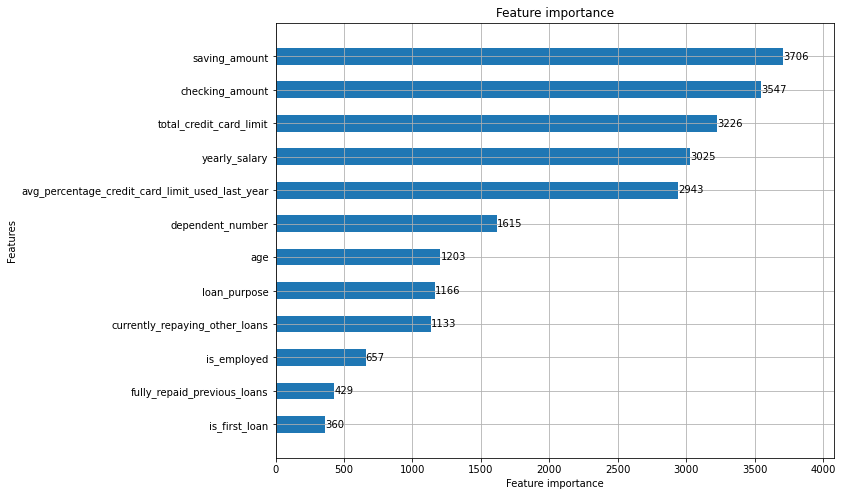

In [22]:
# feature importance

features = clf.feature_name()
importance = clf.feature_importance()

fig, ax = plt.subplots(figsize=(10, 8))
lgb.plot_importance(clf, ax=ax, height=0.5)
plt.show()

It seems that saving amount, checking amount and total credit card limit are the most important factors contributing to loan repaid.

### Model 2: Logistic Regression

In [24]:
# Training the LR model:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.linear_model import LogisticRegression

# Initiating the model:
lr = LogisticRegression()

scores = cross_val_score(lr, X_train, y_train, scoring='accuracy' ,cv=10).mean()

print("The mean accuracy with 10 fold cross validation is %s" % round(scores*100,2))

The mean accuracy with 10 fold cross validation is 83.01


In [25]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

lr = lr.fit(X_train, y_train)
prob = lr.predict_proba(X_test)
predicted= lr.predict(X_test)

In [26]:
prob[:,1], predicted

(array([0.91801127, 0.31750413, 0.96140435, ..., 0.73321486, 0.74170009,
        0.93324523]),
 array([1., 0., 1., ..., 1., 1., 1.]))

In [27]:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=5, random_state=0,multi_class='multinomial').fit(X_train, y_train)
prob2 = lr.predict_proba(X_test)
predicted2= lr.predict(X_test)

In [28]:
prob2, predicted2

(array([[0.08198873, 0.91801127],
        [0.68249587, 0.31750413],
        [0.03859565, 0.96140435],
        ...,
        [0.26678514, 0.73321486],
        [0.25829991, 0.74170009],
        [0.06675477, 0.93324523]]),
 array([1., 0., 1., ..., 1., 1., 1.]))

In [29]:
# Total profit from original bank

loan_paid = y_test.astype(int).values
bank_profit = np.sum(loan_paid*2-1)
print('Bank profit:\t',bank_profit)

Bank profit:	 3440


In [30]:
# Now, let's set a series of threshold to determine whether or not the loan will be given

def calculate_profit(loan_paid, probability, threshold):
    loan_granted = (probability > threshold).astype(int)
    profit = 0
    for i in range(len(loan_paid)):
        if loan_granted[i] == 1:
            if loan_paid[i] == 0:
                profit -= 1
            else:
                profit += 1
                
    return profit

In [31]:
# calculate the profit according to given threshold

thresholds = list(np.linspace(0, 1, 100))
profits = []
profits2 = []

for threshold in thresholds:
    profits.append(calculate_profit(loan_paid, prob[:,1], threshold))
    profits2.append(calculate_profit(loan_paid, prob2[:,1], threshold))

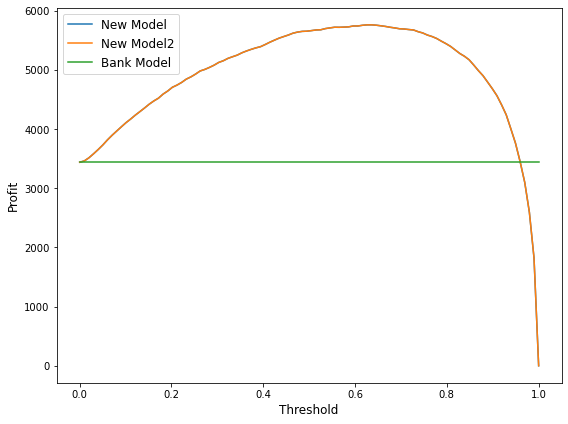

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(thresholds, profits, label='New Model')
ax.plot(thresholds, profits2, label='New Model2')
ax.plot(thresholds, [bank_profit] * len(thresholds), label='Bank Model')
ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Profit', fontsize=12)
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()

### Model 3: Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(
    n_estimators=50,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    #min_weight_fraction_leaf=0.0,
    max_features='auto',
    #max_leaf_nodes=None,
    #min_impurity_decrease=0.0,
    #min_impurity_split=None,
    #bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    #verbose=0,
    #warm_start=False,
    #class_weight='balanced'
)

In [34]:
clf.fit(X_train,y_train)

RandomForestClassifier(max_depth=5, n_estimators=50, n_jobs=-1, random_state=0)

In [35]:
feature_importance_values = clf.feature_importances_

feature_importance_values

array([0.00116574, 0.00111653, 0.00097921, 0.04471463, 0.08270416,
       0.01542995, 0.36040827, 0.3326299 , 0.03497253, 0.12228668,
       0.00036721, 0.0032252 ])

In [36]:
predictions = clf.predict(X_test)

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print('Accuracy: ', accuracy_score(y_test, predictions))
print('confusion matrix:', confusion_matrix(y_test, predictions))
print('F1:', f1_score(y_test, predictions))

Accuracy:  0.9127077387946954
confusion matrix: [[3853  384]
 [ 656 7021]]
F1: 0.9310436281660257


It seems that the three models have not many differences, we can choose any of those three.

### Part 4: Other important variables:

1. famaily situation: Does the borrower have any spounse or relatives that can help to pay off the loan?

2. housing or other real estates: Does the borrower have some properties that can help repay the loan?

3. Education and employment information: People with higher education or high paying job will be more likely to pay off the loan